# Logistic Regression


## Basic imports

In [1]:
from typing import Callable, Dict, Tuple, List, Optional, Any
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

## Part 1

- implement logistic regression algorithm
- generate artificial dataset (make_classificiation)
- fit model
- visualise results

### Task 1

#### Implementation of Logistic regression

In [2]:
INDEX = 239512

class LogisticRegressor(object):

    def __init__(self, eta: float =1e-3, epsilon: float =1e-8, epochs: int =10_000, beta: int =1):
        self.__is_fit: bool =False
        self.__eta: float =eta
        self.__epsilon: float =epsilon
        self.__epochs: int =epochs
        self.__beta: float =beta
        self.__target_Y: np.ndarray =None
        self.__theta: np.ndarray =None
        self.__X: np.ndarray =None
        self.__targets: List[Any]  =[]
        self.__losses: List[float] =[]

    def __gradient(self) -> np.ndarray:
        f_s = self.__predict()
        return self.__X.T @ (-self.__eta * (f_s - self.__target_Y) * f_s * (1 - f_s))

    def __logistic(self, S: np.ndarray) -> np.ndarray:
        return 1.0/ (1 + np.exp(-self.__beta*S))

    def __predict(self, X: Optional[np.ndarray] =None) -> np.ndarray:
        if X is None: X = self.__X
        return self.__logistic(X @ self.__theta)

    def __loss(self, Y_pred: np.ndarray) -> float:
        return np.mean((self.__target_Y - Y_pred)**2)

    def predict(self, X: np.ndarray) -> np.ndarray:
        assert self.__is_fit
        broadcast_sample = np.ones((X.shape[0], X.shape[1] + 1))
        broadcast_sample[:, 1:] = X
        return np.where(self.__predict(broadcast_sample) > 0.5, self.__targets[1], self.__targets[0])

    def fit(self, X, Y, targets=None):
        self.__is_fit = False
        self.__losses = []
        self.__targets = targets if targets is not None else list(sorted(set(Y)))
        self.__target_Y = np.reshape(Y,(Y.shape[0], 1))
        broadcast_train = np.ones((X.shape[0], X.shape[1] + 1))
        broadcast_train[:, 1:] = X
        self.__X = broadcast_train
        self.__theta = np.zeros((self.__X.shape[1], 1)) #np.linalg.inv(self.__X.T @ self.__X) @ self.__X.T @ self.__target_Y

        for i in range(self.__epochs):
            y_pred = self.__predict()
            loss = self.__loss(y_pred)
            self.__losses.append(loss)
            if loss < self.__epsilon: 
                print("Algorithm needed only", i, "iterations to converge")
                break
            self.__theta += self.__gradient()
            
        print("Final loss:", loss)
        self.__is_fit = True

    @property
    def losses(self):
        return np.array(self.__losses, copy=True)

    @property
    def coef_(self):
        return self.__theta.copy()

#### Plotting utilities and normalizer implementations

In [3]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() -1, x.max()+1
    y_min, y_max = y.min() -1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z_r = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z_r, **params)
    ax.contour(xx, yy, Z_r, colors="black", alpha=params['alpha'], antialiased=True, linewidths=0.4 )

def plot_classification_split_using_contourf(title, clf, X, Y, colors, y_label="", x_label="", ax=None, alpha=0.5):
    if ax is None: fig, ax = plt.subplots()

    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)
    targets = list(sorted(set(Y)))
    plot_contours(ax, clf, xx, yy, levels=[min(targets), np.mean(targets), max(targets)], colors=colors, alpha=0.5)

    for cl, color in zip(targets, colors[:2]):
        x0 = X0[Y == cl]
        x1 = X1[Y == cl]
        ax.scatter(x0, x1, c=[color],  s=20, edgecolors='k', zorder=911)

    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title, fontsize=15)
    ax.set_ylim(Y.min()-0.1, Y.max()+0.1)
    ax.set_xlim(X.min()-0.1, X.max()+0.1)
    ax.legend([
            Patch(facecolor=colors[0]),
            Patch(facecolor=colors[1])
        ], [f"Class: {targets[0]}",f"Class: {targets[1]}"], loc='upper left', bbox_to_anchor=(1,1,1,0))
    if ax is None: plt.show()

def display_2D_dataset(X, Y, colors=["chartreuse", "slateblue"], title=""):
    fig, ax = plt.subplots()
    unique_Y = list(sorted(set(Y)))
    assert len(colors) == len(unique_Y) and len(X[0]) == 2
    for y, c in zip(unique_Y, colors):
        x = X[Y == y]
        ax.scatter(x[:, 0], x[:, 1], c=[c], alpha=0.3)
    ax.set_title(title)
    plt.show()

def normalize_data_set(train: np.ndarray, test: np.ndarray =None) -> Tuple[np.ndarray, np.ndarray]:
    scaler = MinMaxScaler()
    scaler.fit(train)
    return (scaler.transform(train), scaler.transform(test) if test is not None else None)

### Task 2

#### Generate and display obtained dataset

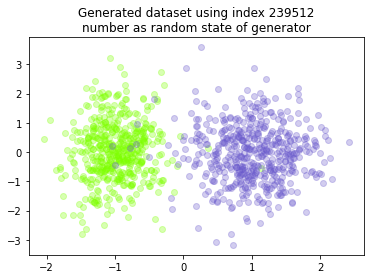

In [4]:
x, y =make_classification(n_samples=1000, n_features=2, n_classes=2, n_clusters_per_class=1, n_informative=1, n_redundant=0, random_state = INDEX)

display_2D_dataset(x, y, title=f"Generated dataset using index {INDEX}\nnumber as random state of generator")

### Task 3

#### Additional imports to compute metrics

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from matplotlib.patches import Patch

#### Split dataset with stratification, normalize data with data leakage prevention

In [6]:
train_x, test_x, train_y, test_y = train_test_split(x, y, stratify=y, test_size=0.2)
train_x, test_x = normalize_data_set(train_x, test_x)

#### Fit logistic classifiers

In [7]:
sk_clf = LogisticRegression()
sk_clf.fit(train_x, train_y)
clf = LogisticRegressor()
clf.fit(train_x, train_y)

Final loss: 0.01920331735035475


#### Display result of loss function minimalization

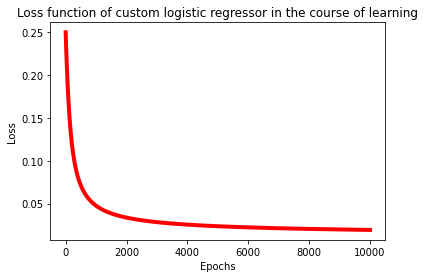

In [8]:
plt.plot(clf.losses, color="red", linewidth=4)
plt.title("Loss function of custom logistic regressor in the course of learning")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#### Display computed boundaries, confusion matrices and computed metrics

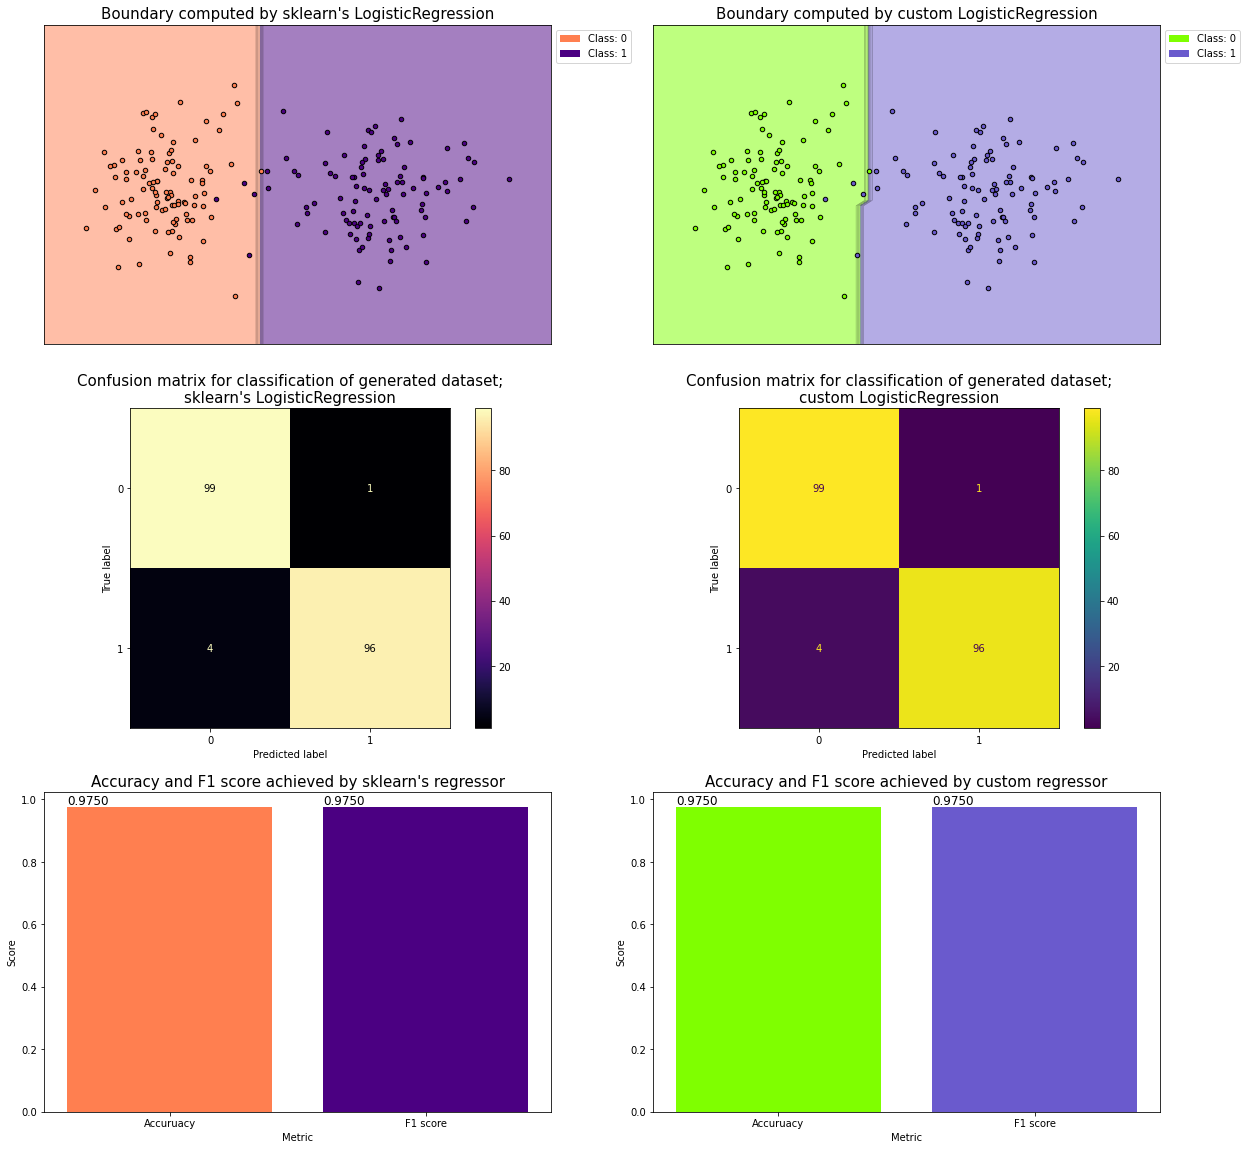

In [9]:
custom_pred = clf.predict(test_x)
sklearn_pred = sk_clf.predict(test_x)

fig, axes = plt.subplots(3, 2, figsize=(20, 20))

plot_classification_split_using_contourf("Boundary computed by sklearn's LogisticRegression", sk_clf, test_x, test_y,["coral", "indigo"], ax=axes[0, 0])
plot_classification_split_using_contourf("Boundary computed by custom LogisticRegression",clf, test_x, test_y, ["chartreuse", "slateblue"], ax=axes[0, 1])

sk_conf_mat = confusion_matrix(test_y, sklearn_pred, labels=list(set(test_y)))
conf_mat = confusion_matrix(test_y, custom_pred, labels=list(set(test_y)))
sk_figure = ConfusionMatrixDisplay(sk_conf_mat, display_labels=list(set(test_y)))
figure = ConfusionMatrixDisplay(conf_mat, display_labels=list(set(test_y)))
sk_figure.plot(ax=axes[1, 0], cmap=plt.get_cmap('magma'))
figure.plot(ax=axes[1, 1])
axes[1, 0].set_title("Confusion matrix for classification of generated dataset;\nsklearn's LogisticRegression", fontsize=15)
axes[1, 1].set_title("Confusion matrix for classification of generated dataset;\ncustom LogisticRegression", fontsize=15)

sk_acc, sk_f1 = (accuracy_score(test_y, sklearn_pred), f1_score(test_y, sklearn_pred, average='weighted'))
acc, f1 = (accuracy_score(test_y, custom_pred), f1_score(test_y, custom_pred, average='weighted'))
axes[2, 0].bar(np.arange(0,2, 1), [sk_acc, sk_f1],  tick_label= ['Accuruacy', 'F1 score'], color=["coral", "indigo"])
axes[2, 0].set_title("Accuracy and F1 score achieved by sklearn's regressor", fontsize=15)
axes[2, 0].set_xlabel("Metric")
axes[2, 0].set_ylabel("Score")
axes[2, 1].bar(np.arange(0,2,1), [acc, f1], tick_label=['Accuruacy', 'F1 score'], color=["chartreuse", "slateblue"])
axes[2, 1].set_title("Accuracy and F1 score achieved by custom regressor", fontsize=15)
axes[2, 1].set_xlabel("Metric")
axes[2, 1].set_ylabel("Score")
for ax in axes[2]:
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}", (p.get_x(), p.get_height()*1.01), fontsize=12)
plt.show()

#### Conclusions
- custom model achieves promising accuracy and f1 score on test dataset.
- custom model determines similar boundary between classes of generated dataset to the computed one by sklearn's model - the differences between results are maybe caused by penalization procedure or other initial hyperparameters selection of sklearn's model

## Part 2

- download dataset "Rain in Australia"/load dataset
- preprocess dataset
- teach model for each region to perform 'tommorow weather forecast'
- check accuracy of models in context of all regions of Australia
- compare results with DummyClassifier


### Task 1


#### Additional imports

In [10]:
import pandas as pd

#### Load dataset

- This dataset contains about 10 years of daily weather observations from many locations across Australia.

- RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

In [11]:
dataset = pd.read_csv("RainInAustralia/weatherAUS.csv", parse_dates=['Date'])

In [12]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,NaN,NaN,E,31.0,ESE,...,27.0,1024.7,1021.2,NaN,NaN,9.4,20.9,No,0.0,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,0.0,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,0.0,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,0.0,No


#### Count of missing values



In [13]:
dataset.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

### Task 2

- preprocess dataset


#### Additional imports

In [14]:
from scipy.sparse import csr_matrix

#### Delete columns, that have more than 30% values missing. Moreover delete RISK_MM

In [15]:
dataset = dataset.drop(columns=["RISK_MM"])
def drop_columns_based_on_percentage_of_missing_values(df: pd.DataFrame, percentage: float=10.0):
    nulls_percentage = df.isna().sum()/len(df.index)
    return df.drop(columns=nulls_percentage[(nulls_percentage*100 > percentage)].index)
dataset = drop_columns_based_on_percentage_of_missing_values(dataset, 30)

#### Replace missing values (categorical/binary - mode, continuous - median)

In [16]:
CONTINUOUS = [ "MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", 
               "WindSpeed9am", "WindSpeed3pm", "Humidity9am", "Humidity3pm", 
               "Pressure9am","Pressure3pm", "Temp9am", "Temp3pm"]
CATEGORICAL_OR_BINARY = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday"]
TARGET = "RainTomorrow"

In [17]:
dataset[CONTINUOUS] = dataset[CONTINUOUS].fillna(dataset[CONTINUOUS].median())
dataset[CATEGORICAL_OR_BINARY] = dataset[CATEGORICAL_OR_BINARY].fillna(dataset[CATEGORICAL_OR_BINARY].agg(lambda col: col.mode().values[0]))

In [18]:
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
142189,2017-06-21,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
142190,2017-06-22,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
142191,2017-06-23,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


#### Perform winsorization of outliers of  1.5 IQR - Inter-Quartile Range

In [19]:
dataset[CONTINUOUS].max()

MinTemp            33.9
MaxTemp            48.1
Rainfall          371.0
WindGustSpeed     135.0
WindSpeed9am      130.0
WindSpeed3pm       87.0
Humidity9am       100.0
Humidity3pm       100.0
Pressure9am      1041.0
Pressure3pm      1039.6
Temp9am            40.2
Temp3pm            46.7
dtype: float64

In [20]:
dataset[CONTINUOUS].min()

MinTemp           -8.5
MaxTemp           -4.8
Rainfall           0.0
WindGustSpeed      6.0
WindSpeed9am       0.0
WindSpeed3pm       0.0
Humidity9am        0.0
Humidity3pm        0.0
Pressure9am      980.5
Pressure3pm      977.1
Temp9am           -7.2
Temp3pm           -5.4
dtype: float64

In [21]:
def winsorize(df: pd.DataFrame):
    Q1s = df.quantile(0.25)
    Q3s = df.quantile(0.75)
    IQR = Q3s - Q1s
    return df.clip(Q1s - 1.5 * IQR, Q3s + 1.5 * IQR, axis=1)
dataset[CONTINUOUS] = winsorize(dataset[CONTINUOUS])

In [22]:
dataset[CONTINUOUS].max()

MinTemp            30.60
MaxTemp            43.65
Rainfall            1.50
WindGustSpeed      68.50
WindSpeed9am       37.00
WindSpeed3pm       40.50
Humidity9am       100.00
Humidity3pm       100.00
Pressure9am      1034.25
Pressure3pm      1032.00
Temp9am            35.30
Temp3pm            40.70
dtype: float64

In [23]:
dataset[CONTINUOUS].min()

MinTemp            -6.20
MaxTemp             2.45
Rainfall            0.00
WindGustSpeed       8.50
WindSpeed9am        0.00
WindSpeed3pm        0.00
Humidity9am        18.00
Humidity3pm         0.00
Pressure9am      1001.05
Pressure3pm       998.40
Temp9am            -1.50
Temp3pm             2.30
dtype: float64

#### Process Date column

- Date can be split into three columns:
    - Year - it can be considered as continuous value
    - Month - it is a cyclic value, so it has to be preprocessed to another two columns to express cyclic relationship between months: sine and cosine can be computed for this purpose
    - Day - the same problem as indicated in month column


In [24]:
dataset["Year"] = dataset.Date.dt.year
dataset["Sine of Day"] = np.sin(2*np.pi * dataset.Date.dt.day/dataset.Date.dt.days_in_month).astype(float)
dataset["Cosine of Day"] = np.cos(2*np.pi * dataset.Date.dt.day/dataset.Date.dt.days_in_month).astype(float)
dataset["Sine of Month"] = np.sin(2*np.pi * dataset.Date.dt.month/12).astype(float)
dataset["Cosine of Month"] = np.cos(2*np.pi * dataset.Date.dt.month/12).astype(float)
CONTINUOUS = CONTINUOUS + ["Year", "Sine of Day", "Cosine of Day", "Sine of Month", "Cosine of Month"]

#### Split dataset to train and test one (example split dataset will be displayed for Canberra)
- 'Location' column is also dropped from region subsets

In [25]:
grouped = dataset.groupby("Location", group_keys=False)
datasets = {}
for group_name in list(grouped.indices.keys()):
    group = grouped.get_group(group_name)
    deleted = group.drop(columns=["Location"])
    datasets[group_name] = train_test_split(deleted, test_size=0.2, stratify=deleted.RainTomorrow)


In [26]:
datasets["Canberra"][0]

,Date,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Sine of Day,Cosine of Day,Sine of Month,Cosine of Month
46047,2012-08-02,-6.2,12.5,0.0,NNW,31.0,N,N,0.0,17.0,...,1018.8,1.1,10.3,No,No,2012,0.394356,0.918958,-8.660254e-01,-0.500000
46807,2014-11-01,14.6,26.5,0.0,NW,67.0,NW,WNW,33.0,35.0,...,1002.7,21.8,20.5,No,No,2014,0.207912,0.978148,-5.000000e-01,0.866025
45686,2011-08-02,0.6,17.8,0.0,W,39.0,N,NNW,0.0,13.0,...,1022.7,4.9,16.5,No,No,2011,0.394356,0.918958,-8.660254e-01,-0.500000
46797,2014-10-22,9.7,24.9,0.0,NNW,31.0,SW,NW,6.0,20.0,...,1019.8,11.2,24.1,No,No,2014,-0.968077,-0.250653,-8.660254e-01,0.500000
46916,2015-02-18,13.1,29.6,0.0,ENE,43.0,ENE,ENE,11.0,19.0,...,1016.8,20.5,26.8,No,No,2015,-0.781831,-0.623490,8.660254e-01,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46424,2013-10-12,0.5,24.0,0.0,NW,39.0,N,NW,4.0,28.0,...,1010.6,10.8,23.1,No,No,2013,0.651372,-0.758758,-8.660254e-01,0.500000
44700,2008-10-15,9.2,19.6,0.6,ENE,31.0,SSE,NNW,4.0,7.0,...,1019.7,11.6,18.4,No,No,2008,0.101168,-0.994869,-8.660254e-01,0.500000
45101,2009-11-20,16.3,39.9,0.0,W,39.0,N,SE,13.0,19.0,...,1015.2,26.8,30.2,No,No,2009,-0.866025,-0.500000,-5.000000e-01,0.866025
45816,2011-12-13,11.2,21.4,0.6,S,41.0,SSE,SW,22.0,11.0,...,1006.5,16.7,19.6,No,No,2011,0.485302,-0.874347,-2.449294e-16,1.000000


In [27]:
datasets["Canberra"][1]

,Date,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Sine of Day,Cosine of Day,Sine of Month,Cosine of Month
46915,2015-02-17,15.6,32.5,0.0,W,41.0,ENE,NNE,7.0,17.0,...,1013.9,22.1,31.2,No,No,2015,-6.234898e-01,-0.781831,8.660254e-01,5.000000e-01
47224,2015-12-27,11.0,24.0,1.5,S,41.0,S,S,24.0,11.0,...,1016.6,15.0,22.1,Yes,No,2015,-7.247928e-01,0.688967,-2.449294e-16,1.000000e+00
47335,2016-04-16,10.2,23.0,0.6,NNW,30.0,SSW,NW,7.0,19.0,...,1019.3,14.0,21.2,No,Yes,2016,-2.079117e-01,-0.978148,8.660254e-01,-5.000000e-01
45628,2011-06-02,5.9,17.7,0.0,E,52.0,SE,NE,11.0,9.0,...,1025.0,10.2,14.6,No,No,2011,4.067366e-01,0.913545,1.224647e-16,-1.000000e+00
47171,2015-11-04,13.9,20.8,0.0,E,39.0,ESE,E,11.0,20.0,...,1015.6,16.8,19.1,No,Yes,2015,7.431448e-01,0.669131,-5.000000e-01,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46983,2015-04-28,2.7,16.5,0.0,E,19.0,SE,N,13.0,11.0,...,1024.5,9.5,15.8,No,No,2015,-4.067366e-01,0.913545,8.660254e-01,-5.000000e-01
45415,2010-09-30,-1.9,14.8,0.6,NNW,31.0,NW,NNW,6.0,24.0,...,1022.4,7.9,14.0,No,No,2010,-1.133108e-15,1.000000,-1.000000e+00,-1.836970e-16
46657,2014-06-04,6.0,13.8,0.0,N,19.0,N,NNW,0.0,9.0,...,1025.4,8.5,13.5,No,No,2014,7.431448e-01,0.669131,1.224647e-16,-1.000000e+00
47041,2015-06-25,1.1,16.0,0.2,SSE,19.0,N,NW,4.0,7.0,...,1024.9,5.0,15.5,No,No,2015,-8.660254e-01,0.500000,1.224647e-16,-1.000000e+00


#### Normalize continuous values (examples for Canberra)

In [28]:
for key in datasets.keys():
    datasets[key][0][CONTINUOUS], datasets[key][1][CONTINUOUS] = normalize_data_set(datasets[key][0][CONTINUOUS], datasets[key][1][CONTINUOUS])

d:\Projects\PUM\pum_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [29]:
datasets["Canberra"][0][CONTINUOUS]

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Sine of Day,Cosine of Day,Sine of Month,Cosine of Month
46047,0.000000,0.221636,0.0,0.347826,0.000000,0.419753,0.620253,0.473684,0.673193,0.607143,0.075235,0.184358,0.5,0.697178,0.959479,0.066987,0.250000
46807,0.679739,0.591029,0.0,0.973913,0.891892,0.864198,0.430380,0.610526,0.088855,0.127976,0.724138,0.469274,0.7,0.603956,0.989074,0.250000,0.933013
45686,0.222222,0.361478,0.0,0.486957,0.000000,0.320988,0.898734,0.357895,0.742470,0.723214,0.194357,0.357542,0.4,0.697178,0.959479,0.066987,0.250000
46797,0.519608,0.548813,0.0,0.347826,0.162162,0.493827,0.734177,0.505263,0.754518,0.636905,0.391850,0.569832,0.7,0.015961,0.374674,0.066987,0.750000
46916,0.630719,0.672823,0.0,0.556522,0.297297,0.469136,0.544304,0.347368,0.537651,0.547619,0.683386,0.645251,0.8,0.109084,0.188255,0.933013,0.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46424,0.218954,0.525066,0.0,0.486957,0.108108,0.691358,0.594937,0.231579,0.453313,0.363095,0.379310,0.541899,0.6,0.825686,0.120621,0.066987,0.750000
44700,0.503268,0.408971,0.4,0.347826,0.108108,0.172840,0.632911,0.400000,0.640060,0.633929,0.404389,0.410615,0.1,0.550584,0.002565,0.066987,0.750000
45101,0.735294,0.944591,0.0,0.486957,0.351351,0.469136,0.139241,0.389474,0.498494,0.500000,0.880878,0.740223,0.2,0.066987,0.250000,0.250000,0.933013
45816,0.568627,0.456464,0.4,0.521739,0.594595,0.271605,0.620253,0.442105,0.206325,0.241071,0.564263,0.444134,0.4,0.742651,0.062827,0.500000,1.000000


In [30]:
datasets["Canberra"][1][CONTINUOUS]

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year,Sine of Day,Cosine of Day,Sine of Month,Cosine of Month
46915,0.712418,0.749340,0.000000,0.521739,0.189189,0.419753,0.582278,0.284211,0.498494,0.461310,0.733542,0.768156,0.8,0.188255,0.109084,0.933013,0.750000
47224,0.562092,0.525066,1.000000,0.521739,0.648649,0.271605,0.329114,0.210526,0.453313,0.541667,0.510972,0.513966,0.8,0.137604,0.844483,0.500000,1.000000
47335,0.535948,0.498681,0.400000,0.330435,0.189189,0.469136,0.835443,0.484211,0.640060,0.622024,0.479624,0.488827,0.9,0.396044,0.010926,0.933013,0.250000
45628,0.395425,0.358839,0.000000,0.713043,0.297297,0.222222,0.759494,0.505263,0.838855,0.791667,0.360502,0.304469,0.4,0.703368,0.956773,0.500000,0.000000
47171,0.656863,0.440633,0.000000,0.486957,0.297297,0.493827,0.683544,0.652632,0.516566,0.511905,0.567398,0.430168,0.8,0.871572,0.834565,0.250000,0.933013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46983,0.290850,0.327177,0.000000,0.139130,0.351351,0.271605,0.607595,0.378947,0.775602,0.776786,0.338558,0.337989,0.8,0.296632,0.956773,0.933013,0.250000
45415,0.140523,0.282322,0.400000,0.347826,0.162162,0.592593,0.455696,0.357895,0.730422,0.714286,0.288401,0.287709,0.3,0.500000,1.000000,0.000000,0.500000
46657,0.398693,0.255937,0.000000,0.139130,0.000000,0.222222,0.962025,0.705263,0.769578,0.803571,0.307210,0.273743,0.7,0.871572,0.834565,0.500000,0.000000
47041,0.238562,0.313984,0.133333,0.139130,0.108108,0.172840,0.987342,0.547368,0.742470,0.788690,0.197492,0.329609,0.8,0.066987,0.750000,0.500000,0.000000


#### Encode one-hot or in binary favour categorical columns
- RainToday column will be mapped to {"Yes" -> 1, "No" -> 0}
- wind-type columns will be mapped on 12 auxiliary columns, since each wind direction contains 3 coordinates (3 x (N,W,S,E)); that mapping should save some space, since there is no need to express all wind directions producing 16 auxiliary columns.

In [31]:
alter_names = ["1st coord N", "1st coord W","1st coord S","1st coord E",
               "2nd coord N", "2nd coord W","2nd coord S","2nd coord E",
               "3rd coord N", "3rd coord W","3rd coord S","3rd coord E"]
binary_cols = []
[[binary_cols.append(f"{wind_col} {alter_name}") for alter_name in alter_names] for wind_col in CATEGORICAL_OR_BINARY[:-1]]
binary_cols.append(CATEGORICAL_OR_BINARY[-1])
wind_dest = {"N":0, 'W':1, "S":2, 'E':3}

def process_wind_dest(x: str):
    arr = np.zeros(12)
    for i, c in enumerate(x):
        arr[4 * i + wind_dest[c]] = 1
    return list(arr)

for key in datasets.keys():
    train, test = datasets[key]
    train[CATEGORICAL_OR_BINARY[-1]] = train[CATEGORICAL_OR_BINARY[-1]].apply(lambda x: 1 if x == "Yes" else 0)
    test[CATEGORICAL_OR_BINARY[-1]] = test[CATEGORICAL_OR_BINARY[-1]].apply(lambda x: 1 if x == "Yes" else 0)
    for wind_col in CATEGORICAL_OR_BINARY[:-1]:
        train, test = datasets[key]
        train_new_cols = [[item for item in row] for row in train[wind_col].apply(lambda x: process_wind_dest(x) ).values]
        train_new_cols = np.array(train_new_cols, dtype=float)
        
        test_new_cols = [[item for item in row] for row in test[wind_col].apply(lambda x: process_wind_dest(x) ).values]
        test_new_cols = np.array(test_new_cols, dtype=float)
    
        joined_train = train.join(pd.DataFrame.sparse.from_spmatrix(csr_matrix(train_new_cols, dtype=float), 
                                 index=train.index, columns = [f"{wind_col} {alter_name}" for alter_name in alter_names]))
        joined_test = test.join(pd.DataFrame.sparse.from_spmatrix(csr_matrix(test_new_cols, dtype=float), 
                                index=test.index, columns = [f"{wind_col} {alter_name}" for alter_name in alter_names]))

        datasets[key] = (joined_train, joined_test)

d:\Projects\PUM\pum_env\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [32]:
datasets["Canberra"][0][binary_cols]

,WindGustDir 1st coord N,WindGustDir 1st coord W,WindGustDir 1st coord S,WindGustDir 1st coord E,WindGustDir 2nd coord N,WindGustDir 2nd coord W,WindGustDir 2nd coord S,WindGustDir 2nd coord E,WindGustDir 3rd coord N,WindGustDir 3rd coord W,...,WindDir3pm 1st coord E,WindDir3pm 2nd coord N,WindDir3pm 2nd coord W,WindDir3pm 2nd coord S,WindDir3pm 2nd coord E,WindDir3pm 3rd coord N,WindDir3pm 3rd coord W,WindDir3pm 3rd coord S,WindDir3pm 3rd coord E,RainToday
46047,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
46807,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
45686,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
46797,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
46916,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46424,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
44700,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
45101,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
45816,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [33]:
datasets["Canberra"][1][binary_cols]

,WindGustDir 1st coord N,WindGustDir 1st coord W,WindGustDir 1st coord S,WindGustDir 1st coord E,WindGustDir 2nd coord N,WindGustDir 2nd coord W,WindGustDir 2nd coord S,WindGustDir 2nd coord E,WindGustDir 3rd coord N,WindGustDir 3rd coord W,...,WindDir3pm 1st coord E,WindDir3pm 2nd coord N,WindDir3pm 2nd coord W,WindDir3pm 2nd coord S,WindDir3pm 2nd coord E,WindDir3pm 3rd coord N,WindDir3pm 3rd coord W,WindDir3pm 3rd coord S,WindDir3pm 3rd coord E,RainToday
46915,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
47224,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
47335,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45628,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
47171,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46983,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
45415,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
46657,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
47041,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0


### Task 3

#### Perform weather prediction per region using LogisticRegression classifier

In [34]:
classifiers = {}
for key in datasets.keys():
    train, test = datasets[key]
    lg = LogisticRegression(max_iter=10_000)
    lg.fit(train[CONTINUOUS + binary_cols], train[TARGET])
    y_pred = lg.predict(test[CONTINUOUS + binary_cols])
    confusion_mat = confusion_matrix(test[TARGET], y_pred)
    accuracy = accuracy_score(test[TARGET], y_pred)
    lg_f1_score = f1_score(test[TARGET], y_pred, average="weighted")
    classifiers[key] = {"classifier":lg, "confusion_mat": confusion_mat, "accuracy":accuracy, "f1_score":lg_f1_score}

d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame

#### Display results

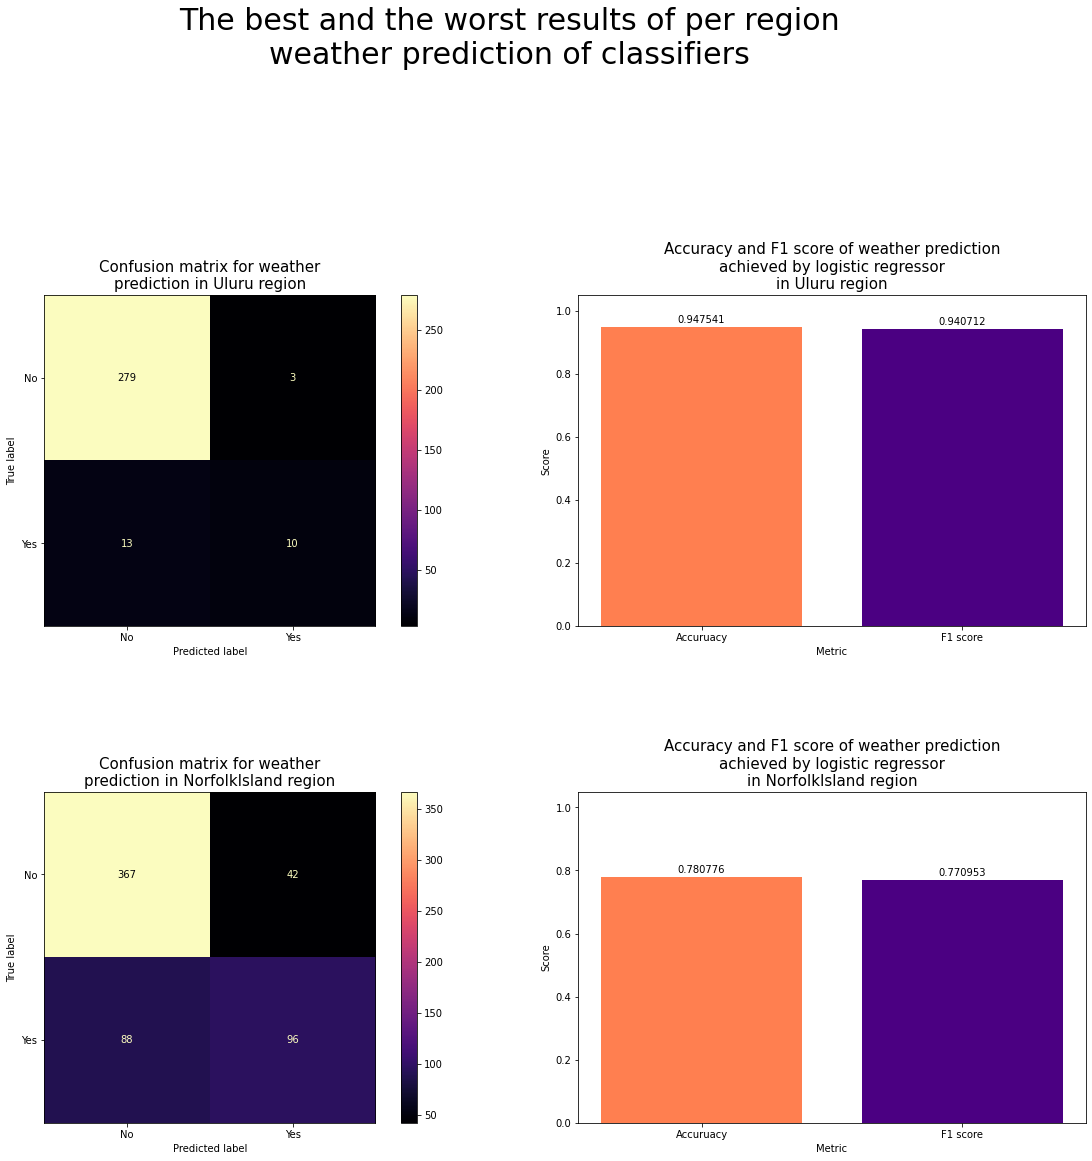

In [35]:
best_worst = (max(classifiers.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])), 
            min(classifiers.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])))
fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1]})
plt.suptitle("The best and the worst results of per region\nweather prediction of classifiers", y=0.9, x=0.5, fontsize=30)

for i, item in enumerate(best_worst):
    key, d = item
    ax_row = axes[i]
    fig_conf = ConfusionMatrixDisplay(d["confusion_mat"], display_labels=list(set(datasets[key][1][TARGET])))
    fig_conf.plot(ax=ax_row[0], cmap=plt.get_cmap('magma'))
    ax_row[0].set_title(f"Confusion matrix for weather\nprediction in {key} region", fontsize=15)
    rects = ax_row[1].bar([0,0.13], [d["accuracy"], d["f1_score"]], width=0.1,  tick_label= ['Accuruacy', 'F1 score'], color=["coral", "indigo"])
    ax_row[1].set_title(f"Accuracy and F1 score of weather prediction\nachieved by logistic regressor\nin {key} region", fontsize=15)
    ax_row[1].set_xlabel("Metric")
    ax_row[1].set_ylabel("Score")
    ax_row[1].set_ylim(0, 1.05)
    ax_row[1].bar_label(rects, padding=2.3)

fig.subplots_adjust(top=0.7, hspace=0.5)
plt.show()

#### Which model performed best, worst?
- the best results were obtained for Uluru region, the worst for NorfolkIsland

In [36]:
print(max(classifiers.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])))

('Uluru', {'classifier': LogisticRegression(max_iter=10000), 'confusion_mat': array([[279,   3],
       [ 13,  10]], dtype=int64), 'accuracy': 0.9475409836065574, 'f1_score': 0.9407119691805818})


In [37]:
print(min(classifiers.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])))

('NorfolkIsland', {'classifier': LogisticRegression(max_iter=10000), 'confusion_mat': array([[367,  42],
       [ 88,  96]], dtype=int64), 'accuracy': 0.7807757166947723, 'f1_score': 0.7709526709315916})


### Task 4

- Check efficiency of per-region classifiers in terms of the whole country

#### Get test samples from the whole Australia
- I decided to get random 4% of each test dataset, to maintain contribution of each region in original dataset

In [38]:
percentage_of_test_sample_from_region = 0.04
test_concatenated = pd.concat([datasets[key][1].sample(frac=percentage_of_test_sample_from_region, random_state=239512) for key in datasets.keys()])

test_concatenated

,Date,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,WindDir3pm 1st coord S,WindDir3pm 1st coord E,WindDir3pm 2nd coord N,WindDir3pm 2nd coord W,WindDir3pm 2nd coord S,WindDir3pm 2nd coord E,WindDir3pm 3rd coord N,WindDir3pm 3rd coord W,WindDir3pm 3rd coord S,WindDir3pm 3rd coord E
96909,2017-05-19,0.384615,0.264840,0.133333,N,0.126126,NNE,NW,0.060606,0.172840,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
93913,2008-09-09,0.170569,0.273973,0.000000,WSW,0.162162,NE,SW,0.272727,0.320988,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
96407,2016-01-01,0.702341,0.736682,0.000000,WNW,0.324324,SSE,W,0.060606,0.469136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95191,2012-05-07,0.421405,0.377473,0.266667,NNW,0.666667,NNE,WNW,0.393939,0.493827,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
96033,2014-12-18,0.428094,0.392694,0.000000,W,0.540541,WNW,SW,0.606061,0.592593,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104292,2012-09-13,0.290970,0.247295,0.000000,SSW,0.757282,S,SSW,0.810811,0.641975,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
105931,2017-05-19,0.234114,0.302937,0.000000,NW,0.097087,WSW,W,0.243243,0.320988,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105620,2016-07-03,0.110368,0.148377,0.000000,NNE,0.349515,NNE,N,0.405405,0.493827,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
103790,2011-03-31,0.438127,0.423493,0.000000,W,0.427184,N,SSW,0.351351,0.098765,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


#### Perform weather prediction in Australia

In [39]:
country_prediction_results = {}
for key in classifiers.keys():
    clf = classifiers[key]['classifier']
    y_country_pred = clf.predict(test_concatenated[CONTINUOUS + binary_cols])
    confusion_mat_ = confusion_matrix(test_concatenated[TARGET], y_country_pred)
    _accuracy = accuracy_score(test_concatenated[TARGET], y_country_pred)
    _lg_f1_score = f1_score(test_concatenated[TARGET], y_country_pred, average="weighted")
    country_prediction_results[key] = {"confusion_mat": confusion_mat_, "accuracy":_accuracy, "f1_score":_lg_f1_score}

d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
d:\Projects\PUM\pum_env\lib\site-packages\sklearn\utils\validation.py:573: UserWarning: pandas.DataFrame

#### Display the results of weather prediction in Australia

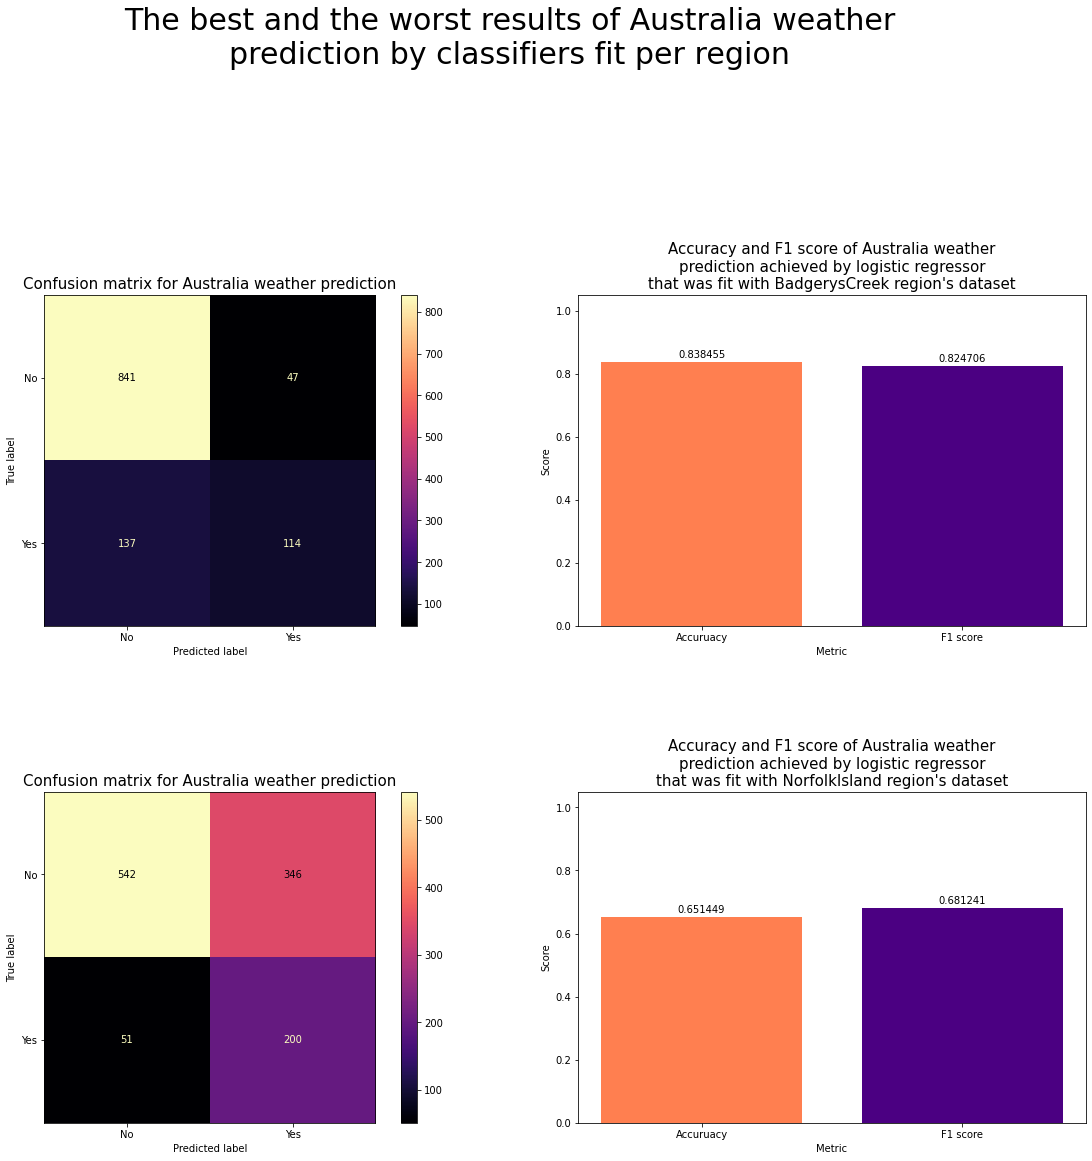

In [40]:
best_worst = (max(country_prediction_results.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])), 
            min(country_prediction_results.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"])))
fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1]})
plt.suptitle("The best and the worst results of Australia weather\nprediction by classifiers fit per region", y=0.9, x=0.5, fontsize=30)

for i, item in enumerate(best_worst):
    key, d = item
    ax_row = axes[i]
    fig_conf = ConfusionMatrixDisplay(d["confusion_mat"], display_labels=list(set(datasets[key][1][TARGET])))
    fig_conf.plot(ax=ax_row[0], cmap=plt.get_cmap('magma'))
    ax_row[0].set_title(f"Confusion matrix for Australia weather prediction", fontsize=15)
    rects = ax_row[1].bar([0,0.13], [d["accuracy"], d["f1_score"]], width=0.1,  tick_label= ['Accuruacy', 'F1 score'], color=["coral", "indigo"])
    ax_row[1].set_title(f"Accuracy and F1 score of Australia weather\nprediction achieved by logistic regressor\nthat was fit with {key} region's dataset", fontsize=15)
    ax_row[1].set_xlabel("Metric")
    ax_row[1].set_ylabel("Score")
    ax_row[1].set_ylim(0, 1.05)
    ax_row[1].bar_label(rects, padding=2.3)

fig.subplots_adjust(top=0.7, hspace=0.5)
plt.show()

#### Compute the mean loss of accuracy and f1 score of classifiers

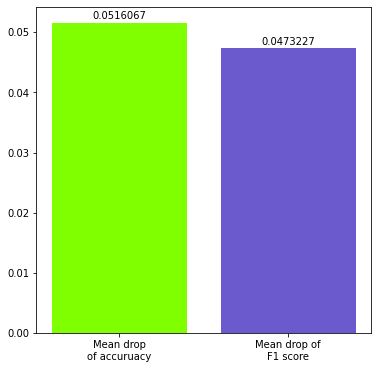

In [41]:
diff_acc_sum = 0
diff_f1_sum = 0
for tup_of_tup in zip(classifiers.items(), country_prediction_results.items()):
    per_region, per_country = tup_of_tup
    diff_acc_sum += per_region[1]["accuracy"] - per_country[1]["accuracy"]
    diff_f1_sum += per_region[1]["f1_score"] - per_country[1]["f1_score"]
fig, ax = plt.subplots(figsize=(6,6))
rects = ax.bar([0, 0.5], [diff_acc_sum/len(country_prediction_results.keys()),diff_f1_sum/len(country_prediction_results.keys())],
        width=0.4,  tick_label= ['Mean drop\nof accuruacy', 'Mean drop of\nF1 score'], color=["chartreuse", "slateblue"])
ax.bar_label(rects, padding=1.5)
plt.show()

#### Observations
- the accuracy of whole models dropped significantly doing prediction on dataset from whole Australia
- the best performance was of BadgerysCreek-teached classifier
- the worst classifier remained the same - maybe the dataset for Norfolk Island has some major issues, or maybe the problem lies in the one-hot mapping of wind-type variables - I decided to put information about single wind-type using 12 columns instead of 16.
- the efficiency depends also on the test dataset, that was obtained from sampling 4% of each region test dataset

### Task 5
- Compare the best LogisticClassifier with DummyClassifier

#### Additional imports

In [42]:
from sklearn.dummy import DummyClassifier

#### Fit DummyClassifier applying the same dataset as the best LogisticRegressor was fit on.

In [43]:
dummy_classifier = DummyClassifier()
max_item = max(country_prediction_results.items(), key=lambda x:(x[1]['accuracy'], x[1]["f1_score"]))
max_key, max_dict = max_item
dummy_train, dummy_test = datasets[max_key]
dummy_classifier.fit(dummy_train[CONTINUOUS + binary_cols], dummy_train[TARGET])

DummyClassifier()

#### Perform weather prediction in Australia using DummyClassifier and store results

In [44]:
y_dummy_pred = dummy_classifier.predict(test_concatenated[CONTINUOUS + binary_cols])
dummy_confusion_mat = confusion_matrix(test_concatenated[TARGET], y_dummy_pred)
dummy_accuracy = accuracy_score(test_concatenated[TARGET], y_dummy_pred)
dummy_f1_score = f1_score(test_concatenated[TARGET], y_dummy_pred, average="weighted")

#### Compare results

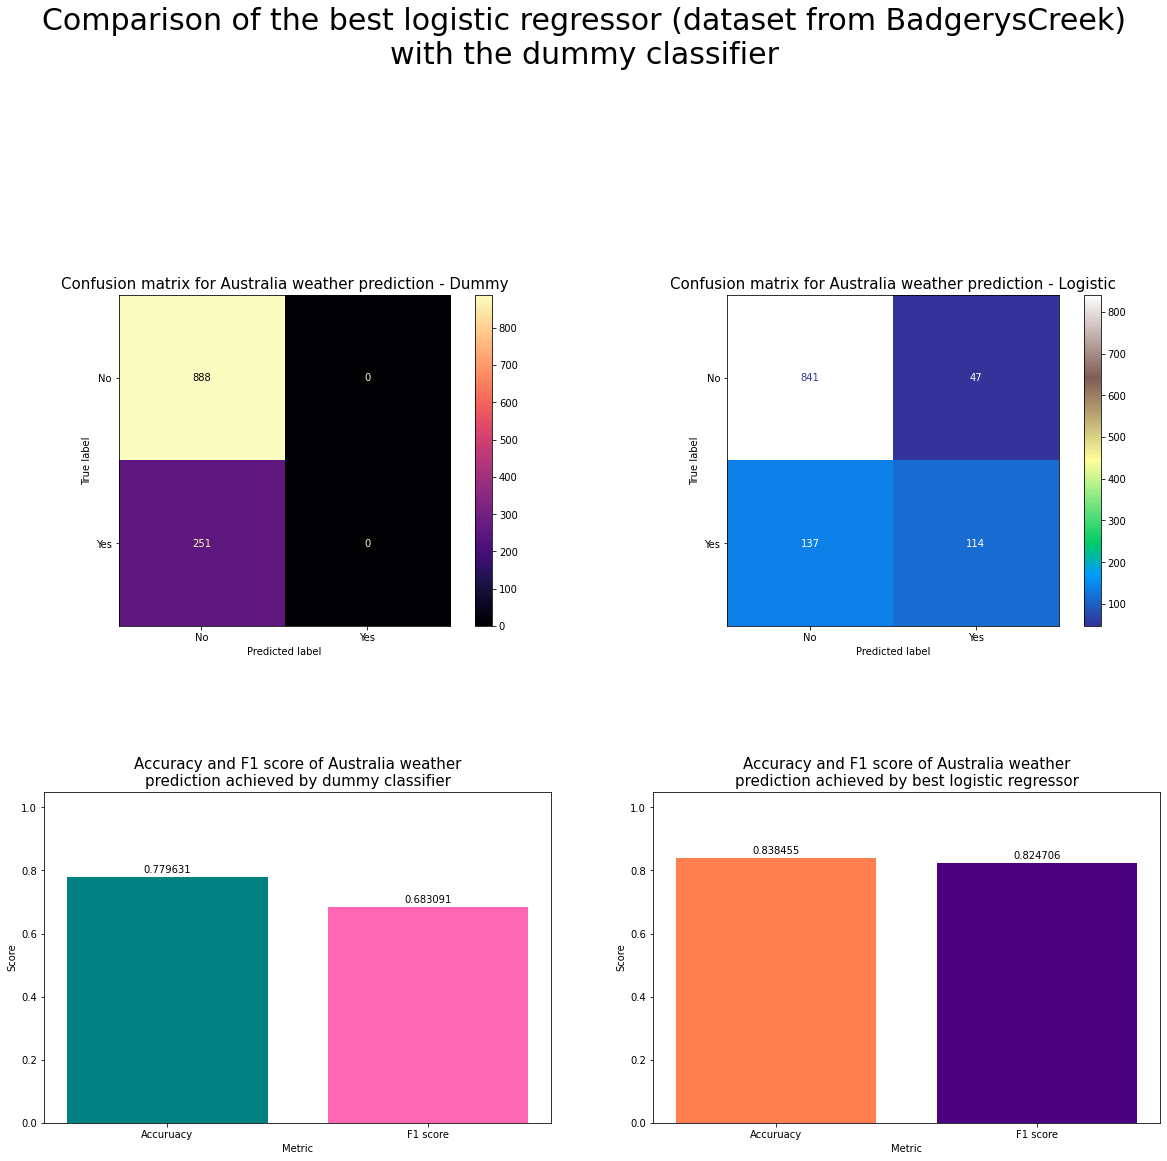

In [46]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), gridspec_kw={'width_ratios': [1, 1]})
plt.suptitle(f"Comparison of the best logistic regressor (dataset from {max_key})\nwith the dummy classifier", y=0.9, x=0.5, fontsize=30)
labels = list(set(dataset[TARGET]))
ax_matrices = axes[0]
ax_bars = axes[1]

dummy_fig = ConfusionMatrixDisplay(dummy_confusion_mat, display_labels=labels)
dummy_fig.plot(ax=ax_matrices[0], cmap=plt.get_cmap('magma'))
log_fig = ConfusionMatrixDisplay(max_dict["confusion_mat"], display_labels=labels)
log_fig.plot(ax=ax_matrices[1], cmap=plt.get_cmap('terrain'))

ax_matrices[0].set_title(f"Confusion matrix for Australia weather prediction - Dummy", fontsize=15)
ax_matrices[1].set_title(f"Confusion matrix for Australia weather prediction - Logistic", fontsize=15)

rects_log = ax_bars[1].bar([0,0.13], [max_dict["accuracy"], max_dict["f1_score"]], 
                       width=0.1,  tick_label= ['Accuruacy', 'F1 score'], color=["coral", "indigo"])
ax_bars[1].set_title(f"Accuracy and F1 score of Australia weather\nprediction achieved by best logistic regressor", fontsize=15)
ax_bars[1].set_xlabel("Metric")
ax_bars[1].set_ylabel("Score")
ax_bars[1].set_ylim(0, 1.05)
ax_bars[1].bar_label(rects_log, padding=2.3)

rects_log = ax_bars[0].bar([0,0.13], [dummy_accuracy, dummy_f1_score], 
                       width=0.1,  tick_label= ['Accuruacy', 'F1 score'], color=["teal", "hotpink"])
ax_bars[0].set_title(f"Accuracy and F1 score of Australia weather\nprediction achieved by dummy classifier", fontsize=15)
ax_bars[0].set_xlabel("Metric")
ax_bars[0].set_ylabel("Score")
ax_bars[0].set_ylim(0, 1.05)
ax_bars[0].bar_label(rects_log, padding=2.3)

fig.subplots_adjust(top=0.7, hspace=0.5)
plt.show()

#### Conclusions
- Fortunately, the best logistic regressor predicts weather more accurately than dummy one. 
- However, the difference between obtained accuracies is relatively small (0.06 higher for Logistic regressor), so the overall score is not perfect in conclusion.